# Grad-CAM Refinement & Testing (Week 2, Day 4)

## Notebook Purpose

This notebook (`04_gradcam_refinement.ipynb`) extends the PneumoDetect explainability workflow by refining and testing the Grad-CAM implementation introduced in Week 2 Day 3.

### Objectives
- Encapsulate Grad-CAM inference in a reusable `generate_cam(image_path, model_path)` function.
- Validate reliability and reproducibility with unit and integration tests.
- Enhance color rendering using OpenCV’s `COLORMAP_JET`.
- Ensure Grad-CAM overlays render consistently across different checkpoints.
- Summarize and visualize Grad-CAM results for misclassified examples.

### Technical Summary
- **Module Updated:** `src/gradcam.py`
- **Tests Added:** `tests/test_gradcam_refinement.py`, `tests/test_gradcam_refinement_integration.py`
- **Outputs Saved To:** `reports/week2_gradcam_refinement/`

### Deliverables
- Passing test suite (`pytest`): verifies shape, normalization (0–1), and overlay integrity.
- Reliable Grad-CAM visualizations confirming robust explainability.

In [23]:
# Add script to include project root in sys.path

import sys
from pathlib import Path

# Add project root (one level up from notebooks/)
project_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent
sys.path.append(str(project_root))

In [24]:
# Import necessary libraries

from pathlib import Path
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from src.gradcam import GradCAM, generate_cam

In [25]:
# ------------------------------------------------------------
# 1. Setup & Directories
# ------------------------------------------------------------
project_root = Path.cwd().parents[0] if Path.cwd().name == 'notebooks' else Path.cwd()
output_dir = project_root / 'reports' / 'week2_gradcam_refinement'
output_dir.mkdir(parents=True, exist_ok=True)

model_path = project_root / 'saved_models' / 'resnet50_baseline.pt'
finetuned_model_path = project_root / 'saved_models' / 'resnet50_best.pt'
image_dir = project_root / 'data' / 'rsna_subset' / 'train_images'

print(f"Using models from: {model_path.parent}")
print(f"Saving refined outputs to: {output_dir}")

Using models from: /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project/saved_models
Saving refined outputs to: /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project/reports/week2_gradcam_refinement


In [26]:
# ------------------------------------------------------------
# 2. Generate Grad-CAM Heatmap Wrapper
# ------------------------------------------------------------
def generate_cam(image_path: Path, model_path: Path) -> np.ndarray:
    """
    Generate a Grad-CAM heatmap for a given image using a model checkpoint.

    Args:
        image_path (Path): Path to an input image.
        model_path (Path): Path to a trained model checkpoint.

    Returns:
        np.ndarray: Normalized Grad-CAM heatmap (H x W, range 0–1).
    """
    if not image_path.exists():
        raise FileNotFoundError(f"Image file not found: {image_path}")
    if not model_path.exists():
        raise FileNotFoundError(f"Model checkpoint not found: {model_path}")

    from src.model import build_resnet50_baseline
    model = build_resnet50_baseline()
    model.load_state_dict(torch.load(model_path, map_location="cpu", weights_only=True))
    model.eval()

    cam = GradCAM(model, target_layer_name="layer4")

    img = Image.open(image_path).convert("RGB")
    tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    # Grad-CAM output is a tensor, convert safely to NumPy
    heatmap = cam.generate(tensor).detach().cpu().numpy()
    heatmap = np.clip(heatmap, 0, 1).astype(np.float32)
    return heatmap


In [27]:
# ------------------------------------------------------------
# 3. Visual Comparison Utility
# ------------------------------------------------------------
def compare_models(image_path: Path, model_paths: list):
    """Compare Grad-CAM results from multiple model checkpoints."""
    results = []
    for path in model_paths:
        heatmap = generate_cam(image_path, path)
        img = cv2.imread(str(image_path))

        # Ensure overlay argument order is (img, heatmap)
        overlay = GradCAM.overlay_heatmap(img, heatmap)

        out_name = f"{image_path.stem}_{path.stem}_overlay.png"
        out_path = output_dir / out_name
        cv2.imwrite(str(out_path), overlay)

        results.append((path.stem, heatmap, overlay))
        print(f"Saved overlay: {out_path.name}")

    return results


In [28]:
# ------------------------------------------------------------
# 4. Plot Visual Comparison (Fixed)
# ------------------------------------------------------------
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from pathlib import Path

def plot_gradcam_comparison(image_path: Path, results):
    """Plot baseline vs fine-tuned Grad-CAM overlays side by side."""
    fig, axes = plt.subplots(1, len(results) + 1, figsize=(12, 4))

    # Show original image
    original = np.array(Image.open(image_path))
    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Display each overlay
    for i, (label, _, overlay) in enumerate(results, start=1):
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        axes[i].imshow(overlay_rgb)
        axes[i].set_title(label.replace("_", " ").title())
        axes[i].axis("off")

    plt.tight_layout()
    plt.show(block=False)   # Force render in VSCode’s Jupyter backend
    display(fig)
    plt.close(fig)


Saved overlay: f6d5b202-5ff1-428a-8d3e-5b64d67fc095_resnet50_baseline_overlay.png
Saved overlay: f6d5b202-5ff1-428a-8d3e-5b64d67fc095_resnet50_best_overlay.png


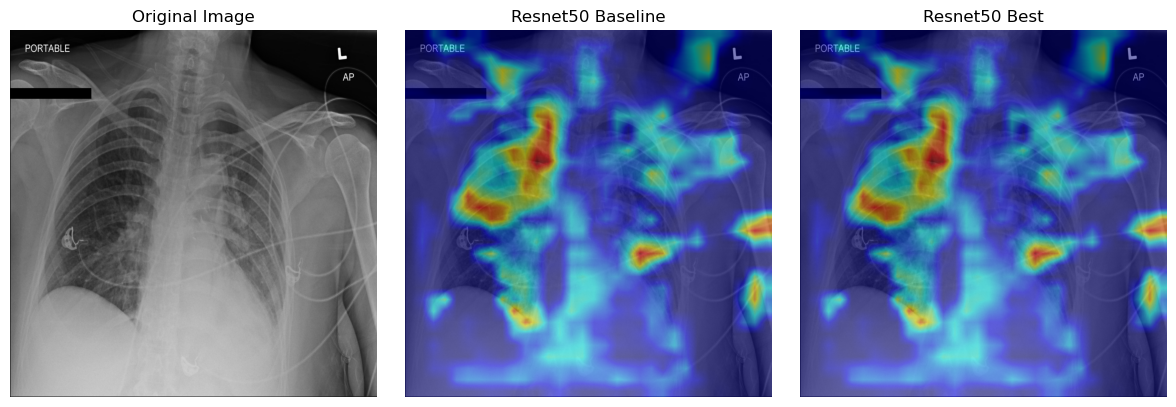

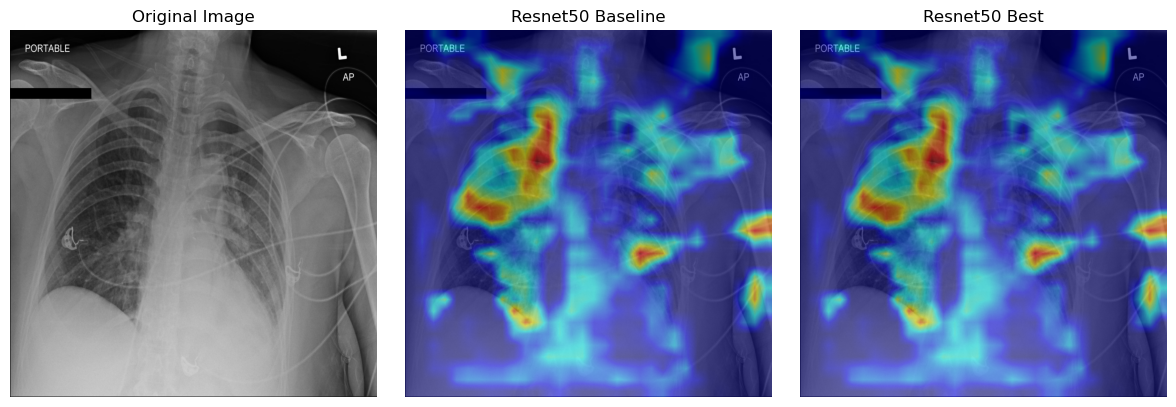

In [29]:
# ------------------------------------------------------------
# 5. Run Sample Comparison and Visualization
# ------------------------------------------------------------
sample_images = list(image_dir.glob('*.png'))[:2]
model_variants = [model_path, finetuned_model_path]

for img_path in sample_images:
    results = compare_models(img_path, model_variants)
    plot_gradcam_comparison(img_path, results)